# Multilinear and polynomial regression

We now want to extend linear regression to $d$ predictor variables $x_1,\ldots,x_d$:

$$
y \approx f(\bfx) = w_1 x_1 + w_2x_2 + \cdots w_d x_d + b.
$$

Observe that we can drop $b$ from the discussion, because we could always define an additional constant predictor variable $x_{d+1}=1$ and get the same effect. So

$$
y \approx f(\bfx) = w_1 x_1 + w_2x_2 + \cdots w_d x_d = \bfw^T\bfx = \bfx^T\bfw,
$$

where we have introduced inner product notation. This is called **multilinear regression**, although it could also be called just *linear regression* in many contexts.

To create the least squares loss function, we use $\bfx_i$ to denote the $i$th row of the $n\times d$ feature matrix $\bfX$. Then  

$$
L(\bfw) = \sum_{i=1}^n (f(\bfx_i)-y_i)^2 = \sum_{i=1}^n (\bfx_i^T\bfw- y_i)^2.
$$

Introducing the shorthand notation (standard linear algebra)

$$
\bfX \bfw = \begin{bmatrix} \bfx_1^T\bfw \\ \bfx_2^T\bfw \\ \vdots \\ \bfx_n^T\bfw \end{bmatrix},
$$

we now get the compact expression

$$
L(\bfw) = \| \bfX \bfw- \bfy \|_2^2.
$$

As in the univariate case, minimizing the loss boils down to solving a linear system of equations for $\bfw$.

## Polynomial regression

An important special case of multilinear regression is when there is initially a single predictor variable $t$, and then we define

$$
x_1 = t^0, \, x_2 = t^1, \ldots, x_d = t^{d-1}.
$$

This makes the regressive approximation into

$$
y \approx w_1 + w_2 t + \cdots + w_d t^{d-1},
$$

which is a polynomial of degree $d-1$. 

## Case study: Fuel efficiency

We return to the data set regarding the fuel efficiency of cars.

In [1]:
import seaborn as sns
cars = sns.load_dataset("mpg")
cars = cars.dropna()
cars

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,usa,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,europe,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger


As we would expect, horsepower and miles per gallon are negatively correlated. However, the relationship is not well captured by a straight line.

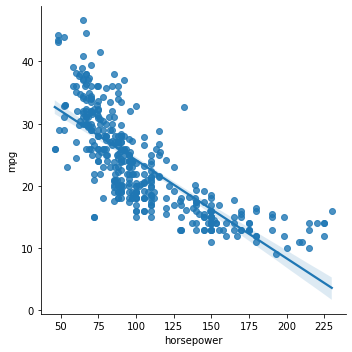

In [2]:
sns.lmplot(data=cars,x="horsepower",y="mpg");

A cubic polynomial produces a much more plausible fit, especially on the right half of the plot.

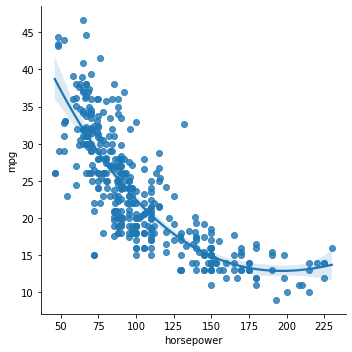

In [3]:
sns.lmplot(data=cars,x="horsepower",y="mpg",order=3);

In order to produce the cubic fit in sklearn, we use the `PolynomialFeatures` preprocessor in a pipeline. If the original horsepower predictor variable is $t$, then the preprocessor will create columns for $1$, $t$, $t^2$, and $t^3$. (Since the constant feature is added in, we don't need to fit the intercept with the linear regressor.)

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np

X = np.array(cars["horsepower"]).reshape(-1,1)
y = cars["mpg"]
lm = LinearRegression(fit_intercept=False)
cubic = make_pipeline(PolynomialFeatures(degree=3),lm)
cubic.fit(X,y)

print("prediction at hp=100:",cubic.predict([[200]]))

prediction at hp=100: [12.90220247]


The prediction above is consistent with the earlier figure. 

We can get the coefficients of the cubic polynomial from the trained regressor:

In [5]:
cubic[1].coef_

array([ 6.06847849e+01, -5.68850128e-01,  2.07901126e-03, -2.14662591e-06])

The coefficients go in order of increasing degree.

If a cubic polynomial can fit better than a line, it's plausible that increasing the degree more will lead to even better fits. In fact, the training error can only go down, because a lower-degree polynomial case is a subset of a higher-degree case.

To explore the effect of degree, we split into train and test sets.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size=0.2,random_state=0)

for deg in range(2,11):
    poly = make_pipeline(PolynomialFeatures(degree=deg),lm)
    poly.fit(X_tr,y_tr)
    print(f"MSE for degree {deg}:",mean_squared_error(y_te,poly.predict(X_te)))

MSE for degree 2: 16.01289461666269
MSE for degree 3: 15.91065108266518
MSE for degree 4: 15.819253166542012
MSE for degree 5: 15.652641443045992
MSE for degree 6: 15.63718971782021
MSE for degree 7: 15.592852998494399
MSE for degree 8: 18.17787140355864
MSE for degree 9: 28.51037146178334
MSE for degree 10: 55.26202163126627


The results above are a classic example of overfitting and the bias–variance tradeoff. A plot of the degree-10 fit shows that the polynomial becomes more oscillatory:

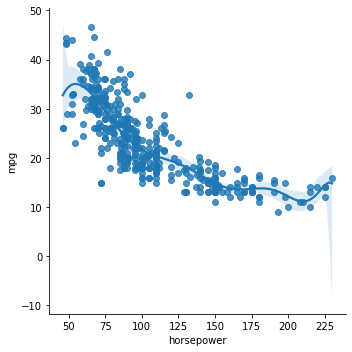

In [7]:
sns.lmplot(data=cars,x="horsepower",y="mpg",order=10);

Now suppose that we keep more of the original data columns and pursue a multilinear fit. We chain it with a `StandardScaler` so that all columns have equal mean and scale.

In [8]:
from sklearn.preprocessing import StandardScaler

X = cars[["horsepower","displacement","cylinders","weight"]]
y = cars["mpg"]
X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size=0.2,random_state=0)

lm = LinearRegression(fit_intercept=True)
pipe = make_pipeline(StandardScaler(),lm)
pipe.fit(X_tr,y_tr)
print(f"MSE for multilinear:",mean_squared_error(y_te,pipe.predict(X_te)))

MSE for multilinear: 18.623882663743327


The fit here is actually a little worse than the low-degree fits on horsepower alone. However, by comparing the coefficients of the individual features, some interesting information emerges:

In [9]:
print(pipe[1].coef_)
print(X.columns)

[-1.58758437  0.19119276 -0.59459762 -4.77122231]
Index(['horsepower', 'displacement', 'cylinders', 'weight'], dtype='object')


We now have a hypothesis that weight is the most significant negative factor for MPG, and by a wide margin.

Finally, we can combine the use of multiple features and higher degree.

In [10]:
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(degree=2),lm)
pipe.fit(X_tr,y_tr)
print(f"MSE for multilinear:",mean_squared_error(y_te,pipe.predict(X_te)))

MSE for multilinear: 14.794088067764827


This is our best regression fit so far.